In [1]:
import discretisedfield as df
import micromagneticmodel as mm
import oommfc as oc

In [2]:
import sys
sys.path.append('..')
from simtools import Strip

In [3]:
yp = 150e-9

In [4]:
pattern = 'ixx'
length = 600e-9
s = Strip(length, 100e-9, 10e-9, 20e-9, '.', initpattern=pattern)
length

6e-07

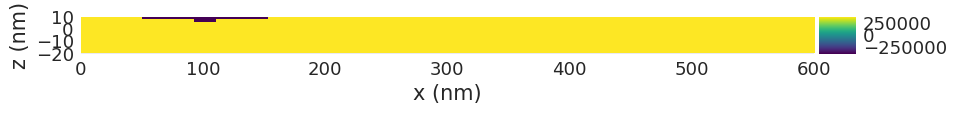

In [5]:
s.system.m.sel('y').z.mpl(figsize=(10, 10))

In [6]:
s.min_drive(fixed=True)

Running OOMMF (ExeOOMMFRunner)[2023/07/17 09:19]... (13.5 s)


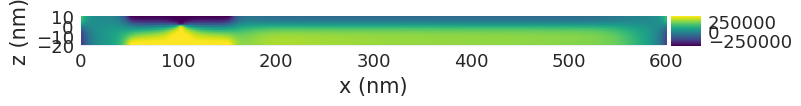

In [7]:
s.system.m.sel('y').z.mpl()

In [8]:
s.min_drive()

Running OOMMF (ExeOOMMFRunner)[2023/07/17 09:19]... (14.2 s)


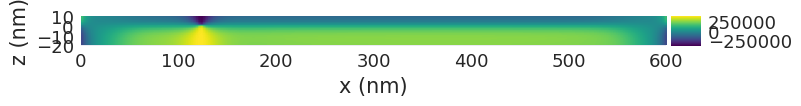

In [9]:
s.system.m.sel('y').z.mpl()

In [10]:
td = oc.TimeDriver()

In [11]:
df.tools.count_bps(s.system.m)

{'bp_number': 1.0,
 'bp_number_hh': 1.0,
 'bp_number_tt': 0.0,
 'bp_pattern_x': '[[-0.0, 49], [-1.0, 191]]'}

In [12]:
df.tools.count_bps(s.system.m, direction='y')

{'bp_number': 1.0,
 'bp_number_hh': 1.0,
 'bp_number_tt': 0.0,
 'bp_pattern_y': '[[-0.0, 20], [-1.0, 20]]'}

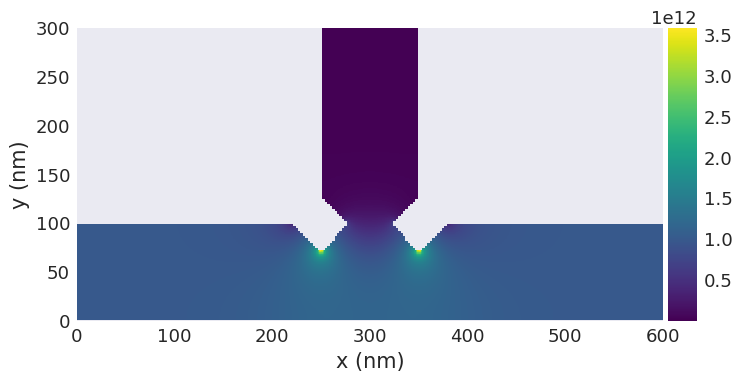

In [13]:
j_profile_left_right = df.Field.from_file('current-left-right.omf')
j_profile_left_right.valid = 'norm'

j_profile_left_right.mesh.scale(1e-9, inplace=True, reference_point=(0, 0, 0))
j_profile_left_right.mesh.translate((0, 0, -20e-9), inplace=True)
j_profile_left_right.sel('z').norm.mpl()

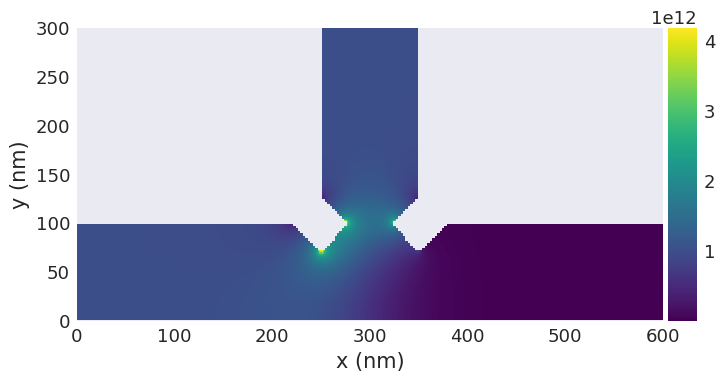

In [14]:
j_profile_left_top = df.Field.from_file('current-left-top.omf')
j_profile_left_top.valid = 'norm'

j_profile_left_top.mesh.scale(1e-9, inplace=True, reference_point=(0, 0, 0))
j_profile_left_top.mesh.translate((0, 0, -20e-9), inplace=True)
j_profile_left_top.sel('z').norm.mpl()

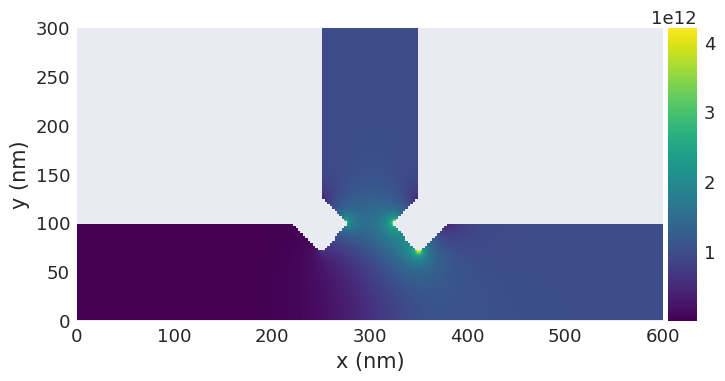

In [15]:
j_profile_top_right = df.Field.from_file('current-top-right.omf')
j_profile_top_right.valid = 'norm'

j_profile_top_right.mesh.scale(1e-9, inplace=True, reference_point=(0, 0, 0))
j_profile_top_right.mesh.translate((0, 0, -20e-9), inplace=True)
j_profile_top_right.sel('z').norm.mpl()

In [16]:
import numpy as np

In [17]:
norm = np.full(j_profile_left_right.norm.array.shape, 384e3)
norm[~j_profile_left_right.valid] = 0

In [18]:
m0 = np.full(j_profile_left_right.array.shape, (-1, 0, 0))

In [19]:
m0[:,:20,:] = (1, 0, 0)

In [20]:
f = df.Field(j_profile_left_right.mesh, nvdim=3, value=m0, norm=norm)

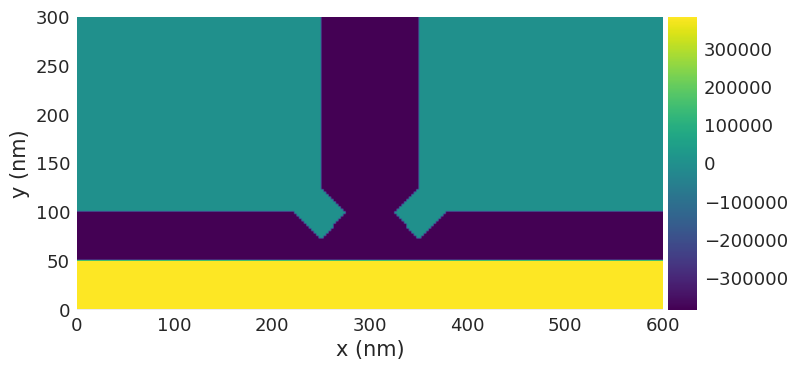

In [21]:
f.sel(z=1e-9).x.mpl()

In [22]:
f.array[f.mesh.region2slices(s.system.m.mesh.region)] = s.system.m.array.copy()

In [23]:
f.norm = norm

In [24]:
sr = s.system.m.mesh.subregions.copy()

In [25]:
sr['freebottom'] = df.Region(p1=(0, 0, -20e-9), p2=(length, j_profile_left_right.mesh.region.pmax[1], 0))
sr['freetop'] = df.Region(p1=(0, 0, 0), p2=(length, j_profile_left_right.mesh.region.pmax[1], 10e-9))

In [26]:
s.system.m = f

In [27]:
s.system.m.mesh.subregions = sr

In [28]:
td = oc.TimeDriver()

In [29]:
td.drive(s.system, t=1e-9, n=1)

Running OOMMF (ExeOOMMFRunner)[2023/07/17 09:20]... (11.8 s)


In [30]:
s.system.m.valid = 'norm'

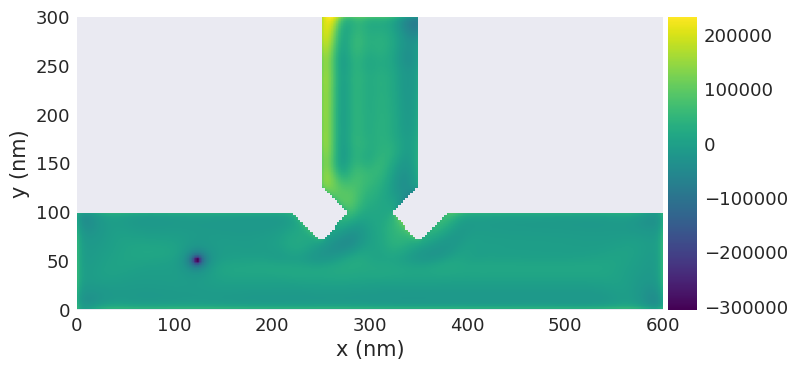

In [31]:
s.system.m.sel(z=1e-9).z.mpl()

In [32]:
subregions = {
    'bottom': df.Region(p1=(0, 0, -20e-9), p2=(length, j_profile_left_right.mesh.region.pmax[1], 0)),
    'top': df.Region(p1=(0, 0, 0), p2=(length, j_profile_left_right.mesh.region.pmax[1], 10e-9))
}

s.system.m.mesh.subregions = subregions
s.system.energy.dmi.D = {'bottom': -0.00158, 'top': 0.00158}

In [33]:
md = oc.MinDriver()

In [34]:
md.drive(s.system)

Running OOMMF (ExeOOMMFRunner)[2023/07/17 09:20]... (38.3 s)


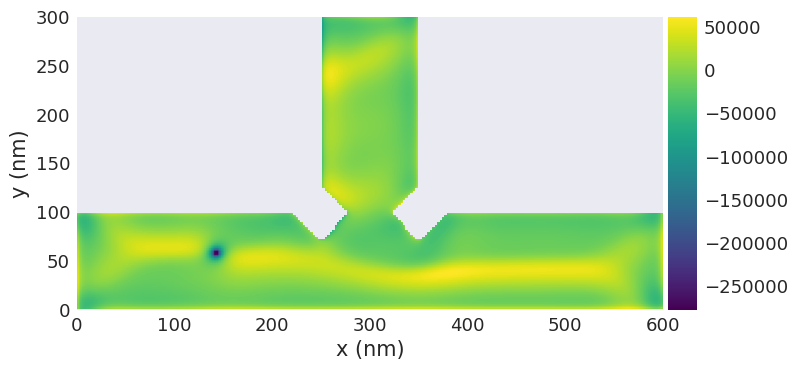

In [35]:
s.system.m.sel(z=1e-9).z.mpl()

In [36]:
df.tools.count_bps(s.system.m)

{'bp_number': 1.0,
 'bp_number_hh': 1.0,
 'bp_number_tt': 0.0,
 'bp_pattern_x': '[[-0.0, 57], [-1.0, 183]]'}

In [37]:
df.tools.count_bps(s.system.m, direction='y')

{'bp_number': 1.0,
 'bp_number_hh': 1.0,
 'bp_number_tt': 0.0,
 'bp_pattern_y': '[[-0.0, 23], [-1.0, 97]]'}

In [38]:
td = oc.TimeDriver()

In [39]:
muB = 9.274e-24

def J2ux(J, P=.5):
    Ms = 384e3
    return J * P * mm.consts.g * muB / (2 * mm.consts.e * Ms)

In [40]:
j_profile_left_right.sel(x=(0, 100e-9)).sel(y=(0, 100e-9)).mean()

array([ 9.99970375e+11, -1.12353390e+09, -1.32383421e+05])

---
## left -> right

In [41]:
s.system.dynamics += mm.ZhangLi(u=0, beta=0.56)

Running OOMMF (ExeOOMMFRunner)[2023/07/17 09:21]... (1987.4 s)


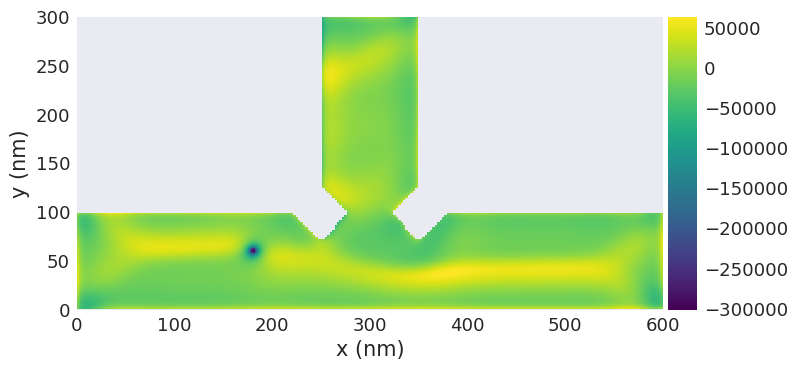

In [42]:
u_field = df.Field(s.system.m.mesh, nvdim=3, value=J2ux(j_profile_left_right.array * .5), valid=s.system.m.valid)
s.system.dynamics.zhangli.u = u_field

td.drive(s.system, t=2e-9, n=50)
s.system.m.sel(z=1e-9).z.mpl()

Running OOMMF (ExeOOMMFRunner)[2023/07/17 09:54]... (723.2 s)


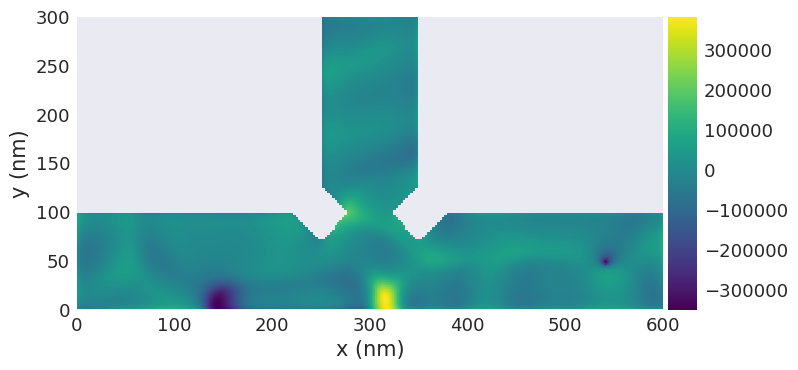

In [43]:
u_field = df.Field(s.system.m.mesh, nvdim=3, value=J2ux(j_profile_left_right.array * 5), valid=s.system.m.valid)
s.system.dynamics.zhangli.u = u_field

td.drive(s.system, t=.7e-9, n=70)
s.system.m.sel(z=1e-9).z.mpl()

Running OOMMF (ExeOOMMFRunner)[2023/07/17 10:07]... (881.0 s)


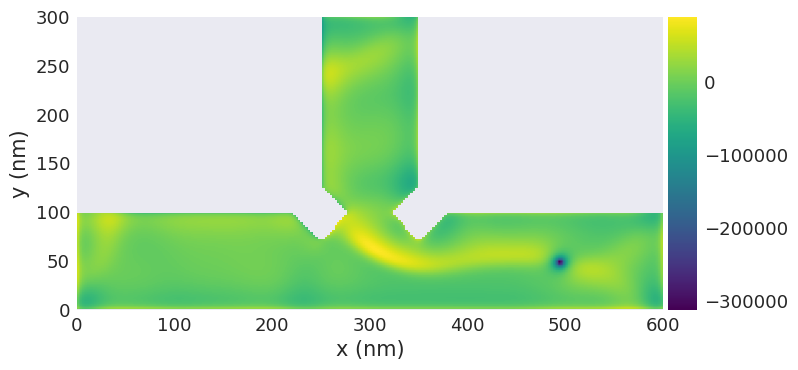

In [44]:
s.system.dynamics -= s.system.dynamics.zhangli

td.drive(s.system, t=2e-9, n=50)

s.system.m.sel(z=1e-9).z.mpl()

---
## right -> top

In [45]:
s.system.dynamics += mm.ZhangLi(u=0, beta=0.56)

Running OOMMF (ExeOOMMFRunner)[2023/07/17 10:21]... (2048.3 s)


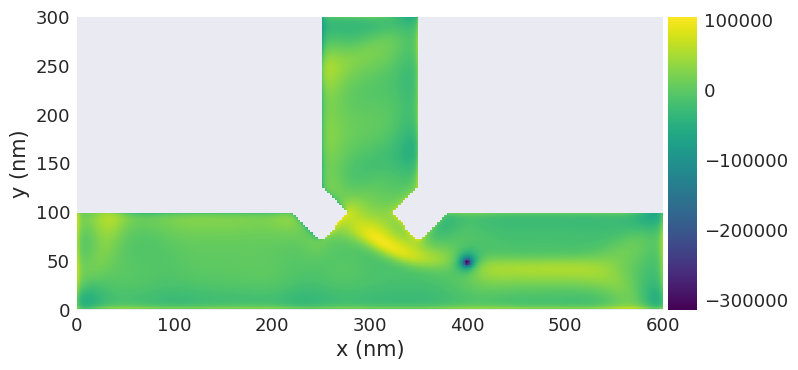

In [46]:
u_field = df.Field(s.system.m.mesh, nvdim=3, value=J2ux(j_profile_top_right.array * -0.5), valid=s.system.m.valid)
s.system.dynamics.zhangli.u = u_field

td.drive(s.system, t=2e-9, n=50)
s.system.m.sel(z=1e-9).z.mpl()

Running OOMMF (ExeOOMMFRunner)[2023/07/17 10:55]... (512.1 s)


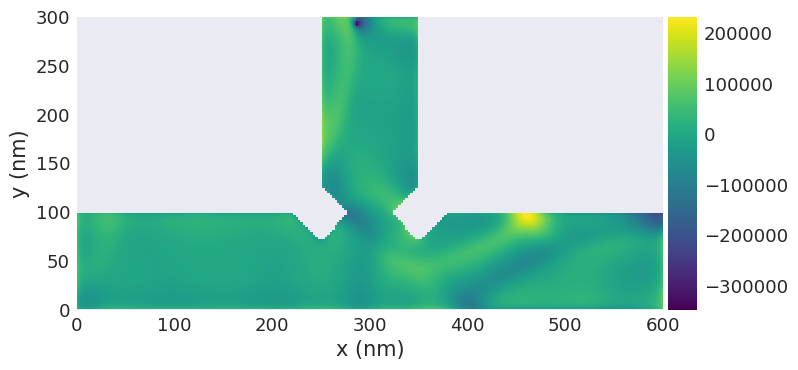

In [47]:
u_field = df.Field(s.system.m.mesh, nvdim=3, value=J2ux(j_profile_top_right.array * -5), valid=s.system.m.valid)
s.system.dynamics.zhangli.u = u_field

td.drive(s.system, t=.50e-9, n=50)
s.system.m.sel(z=1e-9).z.mpl()

Running OOMMF (ExeOOMMFRunner)[2023/07/17 11:04]... (1747.7 s)


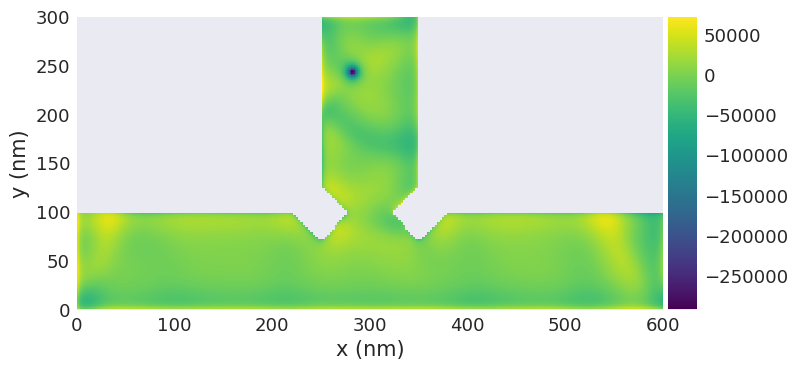

In [48]:
s.system.dynamics -= s.system.dynamics.zhangli

td.drive(s.system, t=4e-9, n=100)

s.system.m.sel(z=1e-9).z.mpl()

---
## top -> left

In [49]:
s.system.dynamics += mm.ZhangLi(u=0, beta=0.56)

Running OOMMF (ExeOOMMFRunner)[2023/07/17 11:33]... (2040.9 s)


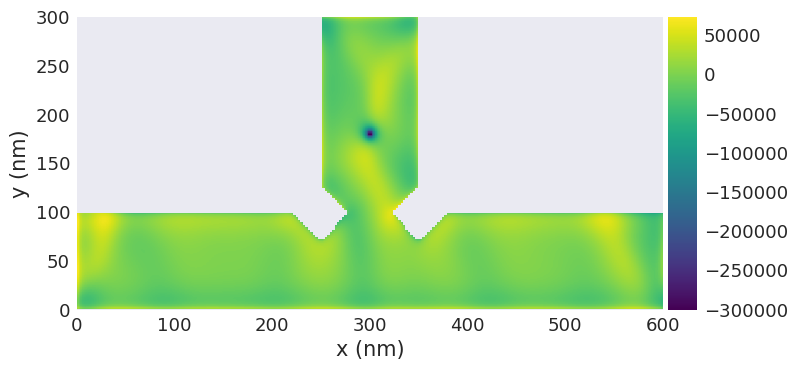

In [50]:
u_field = df.Field(s.system.m.mesh, nvdim=3, value=J2ux(j_profile_left_top.array * -0.5), valid=s.system.m.valid)
s.system.dynamics.zhangli.u = u_field

td.drive(s.system, t=2e-9, n=50)
s.system.m.sel(z=1e-9).z.mpl()

Running OOMMF (ExeOOMMFRunner)[2023/07/17 12:07]... (661.3 s)


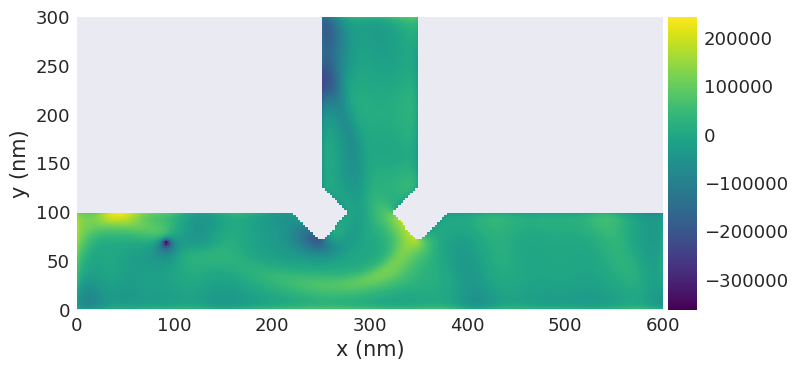

In [51]:
u_field = df.Field(s.system.m.mesh, nvdim=3, value=J2ux(j_profile_left_top.array * -5), valid=s.system.m.valid)
s.system.dynamics.zhangli.u = u_field

td.drive(s.system, t=.7e-9, n=70)
s.system.m.sel(z=1e-9).z.mpl()

Running OOMMF (ExeOOMMFRunner)[2023/07/17 12:18]... (842.0 s)


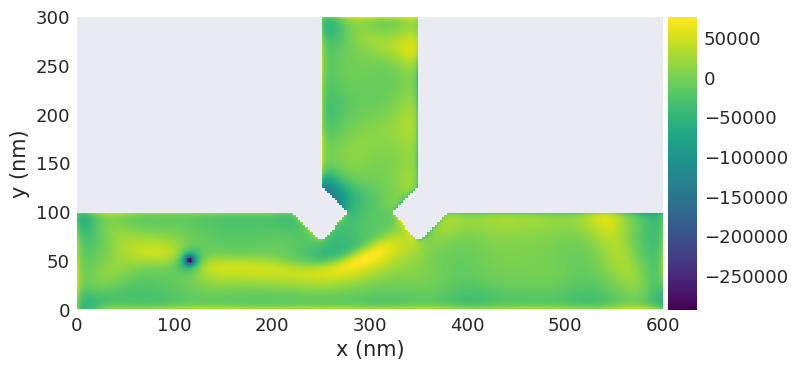

In [52]:
s.system.dynamics -= s.system.dynamics.zhangli

td.drive(s.system, t=2e-9, n=50)

s.system.m.sel(z=1e-9).z.mpl()